In [51]:
import crypten
import torch
import numpy as np
import matplotlib.pyplot as plt
import crypten.mpc as mpc

import sys
sys.path.append("../") # go to parent dir
sys.path.append("../../") # go to parent parent dir
sys.path.append("../helpers/")
sys.path.append("../helpers/utils")
sys.path.append("../helpers/mpc")
import utils
import sparse_linreg_damgard

import time

crypten.init()

torch.set_num_threads(1)
torch.set_printoptions(precision=32) # default

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/opt/anaconda3/envs/mpc/lib/python3.7/site-packages/crypten/__init__.py:64: RuntimeWarning: CrypTen is already initialized.
  warnings.warn("CrypTen is already initialized.", RuntimeWarning)


In [75]:
@mpc.run_multiprocess(world_size=2)
def share_testing(noise_input, noise_output):
    noise_input_shared = crypten.cryptensor(noise_input, ptype=crypten.mpc.arithmetic)
    noise_output_shared = crypten.cryptensor(noise_output, ptype=crypten.mpc.arithmetic)

    crypten.print(f"Source {0} {noise_input_shared.get_plain_text()}")
    crypten.print(f"Source {0} {noise_input}")
    print("\n__________________________\n")
    crypten.print(f"Source {0} {noise_output_shared.get_plain_text()}")
    crypten.print(f"Source {0} {noise_output}")

In [77]:
noise_input = [-0.40807482,  1.07505626,  0.06985295, -0.07706185, -0.39470101]
noise_output = [-0.19805427,  0.26415289,  0.03860164,  0.63382055, 0.01970417]
share_testing(torch.tensor(noise_input), torch.tensor(noise_output));

Source 0 tensor([-0.4080657958984375,  1.0750427246093750,  0.0698394775390625,
        -0.0770568847656250, -0.3946990966796875])
__________________________


Source 0 tensor([-0.4080748260021210,  1.0750563144683838,  0.0698529481887817,
        -0.0770618468523026, -0.3947010040283203])

__________________________

Source 0 tensor([-0.1980438232421875,  0.2641448974609375,  0.0385894775390625,
         0.6338195800781250,  0.0196990966796875])
Source 0 tensor([-0.1980542689561844,  0.2641528844833374,  0.0386016406118870,
         0.6338205337524414,  0.0197041705250740])


In [18]:
def generate_nb_noise(n_succ, prob_succ, size, n_servers):
    full_noise = np.zeros(size)
    for i in range(n_servers):
        noise = np.random.negative_binomial(n_succ, prob_succ, size)
        full_noise += noise
    return full_noise

def generate_noise_nb(total_servers, corrupted_servers, ebs, size):
    noise_p = 1 - 2.71 ** (-ebs / 2)
    noise_input = generate_nb_noise(1 / (total_servers - corrupted_servers), noise_p, size, total_servers)
    noise_output = generate_nb_noise(1 / (total_servers - corrupted_servers), noise_p, size, 1)
    return noise_input, noise_output

In [23]:
def generate_laplace_noise(lmb, ebs, dta, s, d, n_servers):
    full_noise = np.zeros(d)
    for i in range(n_servers):
        s = max(s, 1) # to avoid generating zero noise when the sparsity is 0
        scale = (lmb / ebs) * (2 * np.sqrt(3 * s * np.log(1 / dta)))
        noise = np.random.laplace(0, scale, d)
        full_noise += noise
    return full_noise

In [187]:
order = 3
d = 20
T = 100
eta = 0.1
n = 1
result = {}
k = 5

result = {}
result[0] = it_err_no_noise

for x in [5, 10, 15, 20]:
    data = utils.sample_dataset(n * (10 ** order), d, 0.05, k, 1)
    it_err, last_err = sparse_linreg_damgard.solve(data, (0.00005, x, x), k, T, a=64, c=0, eta=0.1, eps=0.001)
    result[x] = it_err
    print(f'done x = {x}')

0
10
20
30
40
50
60
70
80
90
done x = 5
0
10
20
30
40
50
60
70
80
90
done x = 10
0
10
20
30
40
50
60
70
80
90
done x = 15
0
10
20
30
40
50
60
70
80
90
done x = 20


In [188]:
print(it_err_no_noise)

[0.967514486889491, 0.9361118617600657, 0.9057314152189754, 0.8763399015467752, 0.8479301203789905, 0.8204369702533932, 0.7938420133067972, 0.7681322629347105, 0.7432663264217405, 0.7192112456326838, 0.6959410671587104, 0.6734308517319458, 0.6516579252922803, 0.6306074543478439, 0.6102389988945545, 0.5905455385435572, 0.5714829725863713, 0.5530391820667824, 0.535207111442767, 0.5179560318734363, 0.5012663182269266, 0.4851211277729717, 0.4695118405432951, 0.4543990745675175, 0.43978943708961343, 0.42565710123491546, 0.41198163736968635, 0.3987469823494586, 0.3859445406706744, 0.373548708077828, 0.3615688380393945, 0.3499749525567899, 0.33875059055604084, 0.32789934193558185, 0.3173956572119773, 0.3072389575927993, 0.29739305341447986, 0.28787113758221866, 0.27865893495476673, 0.26973945220643236, 0.2611283907250459, 0.25278521209655663, 0.24471258646486244, 0.23689878233033865, 0.2293451614095834, 0.22204498240606665, 0.21496645995037822, 0.2081176060340727, 0.20149890812029284, 0.19508

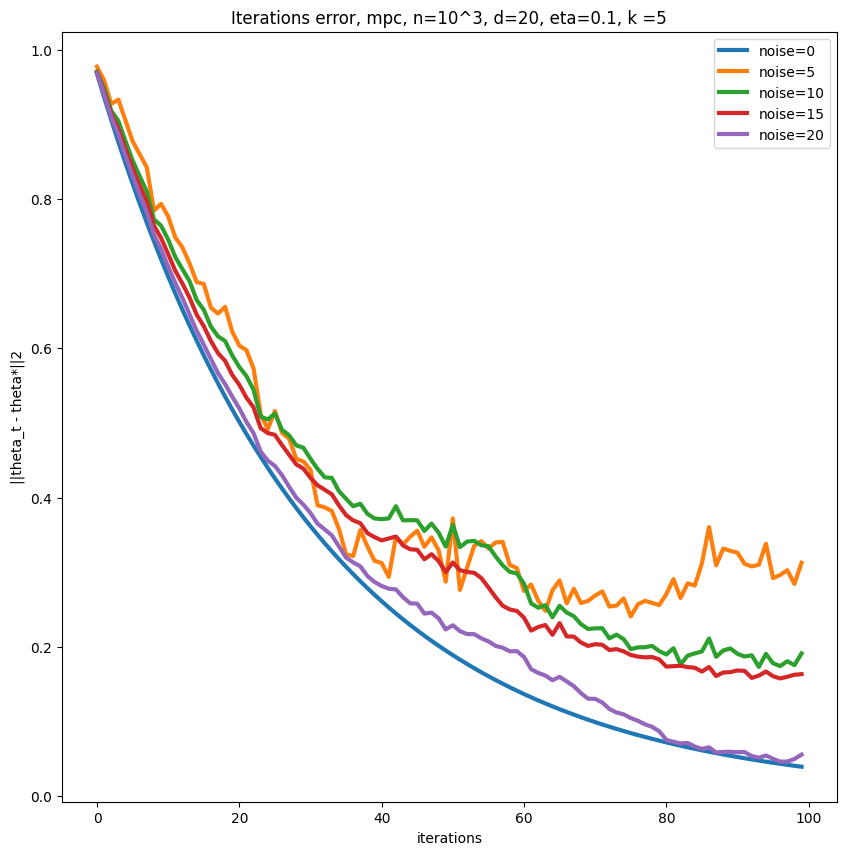

In [191]:
utils.plot_error_by_iteration_and_dict_key(
    result,
    title=f'Iterations error, mpc, n={n}0^{order}, d={d}, eta={eta}, k ={k}',
    xlabel="iterations",
    ylabel='||theta_t - theta*||2',
    line_label="noise")